该文件是一个赋值文件，用于计算一些值

# 计算阈值

计算结果1的阈值

In [1]:
#计算结果一的阈值
from MyModel import Classification
from HaoChiUtils import DataAnalyzer as DA
import os
def get_result1_threshold(file_path="用于计算结果1阈值和熵率阈值的用户文本"):
    label_list=['快乐','恐惧','愤怒','惊讶','喜爱','厌恶','悲伤']
    
    weight_list=[-1,0.5,1,0,-1.5,0.5,1.3]
    # 初始化模型
    myClassification=Classification("bert_model")
    # 读取文本
    fir_list=os.listdir(file_path)
    total_result1=0
    for i in fir_list:
        data = DA.get_dataList(file_path+'/'+i,min_len=6)  # 获取文本数据
        # 预测
        pre=myClassification.get_predict_result(data)  # 使用模型进行预测
        res_dict=DA.calculate_label_proportions(pre,label_list=label_list)  # 计算预测结果中各标签的比例
        result1=0
        # print("res_dict：",res_dict)
        for i in range(len(label_list)):
            result1=result1+res_dict[label_list[i]]*weight_list[i]*100  # 根据权重计算结果
        total_result1+=result1
    return total_result1/len(fir_list)*0.7  # 返回平均结果
filepath="用于计算结果1阈值和熵率阈值的用户文本"
res=get_result1_threshold(filepath)
print("结果1的阈值为:",res)

c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


结果1的阈值为: 58.32166666666665


计算熵率的阈值

In [8]:
import math
from MyModel import Classification
from HaoChiUtils import DataAnalyzer as DA
import os
#计算判断熵率高低的阈值
def get_Entropy_threshold(file_path="用于计算结果1阈值和熵率阈值的用户文本"):
    label_list=['快乐','恐惧','愤怒','惊讶','喜爱','厌恶','悲伤']
    label_dict = {label: 0 for label in label_list}
    # 初始化模型
    myClassification=Classification("bert_model")
    # 读取文本
    fir_list=os.listdir(file_path)
    # total_result1=0
    for i in fir_list:
        data = DA.get_dataList(file_path+'/'+i,min_len=6)  # 获取文本数据
        # 预测
        pre=myClassification.get_predict_result(data)  # 使用模型进行预测
        res_dict=DA.calculate_label_proportions(pre,label_list=label_list)  # 计算预测结果中各标签的比例
        # result1=0
        # print("res_dict：",res_dict)
        for i in range(len(label_list)):
            label_dict[label_list[i]]+=res_dict[label_list[i]]
        # total_result1+=result1
    for i in label_dict.keys():
        label_dict[i]=label_dict[i]/(len(fir_list))
    total_pi=0
    for i in label_list:
        if i =='惊讶':
            continue
        pi=label_dict[i]
        total_pi+=-pi*math.log2(pi)
    return total_pi/20
filepath="用于计算结果1阈值和熵率阈值的用户文本"
res=get_Entropy_threshold(filepath)
print("熵率的阈值 = ",res)

熵率的阈值 =  0.07628502665043618


计算情绪变化的阈值

In [7]:
#计算情绪变化阈值
from FunctionalInterface import TextEmotionAnalyzer as TEA 
import os
import math
#求最大最小值
def maxmin(pro_list):
    Max=0
    Min=1
    for i in pro_list:
        if i >0 and i<Min:
            Min=i
        if i>Max:
            Max=i 
    return Max,Min
#归一化,传入一个字典
def calculate_mood_change_threshold(pro_dict):
    # pro_keys=pro_dict.keys()
    pro_values=pro_dict.values()
    pro_max,pro_min=maxmin(pro_values)
    div=pro_max-pro_min
    if div ==0:
        div=1
    pro_values=[max((x-pro_min)/div,0) for x in pro_values]
    mean_u=sum(pro_values)/len(pro_values)
    S_square=0
    x_sum=0
    for x in pro_values:
        x_sum+=(x-mean_u)*(x-mean_u)
    S_square=x_sum/len(pro_values)
    S=round(math.sqrt(S_square),2)
    return S
#开始计算
tea=TEA()
res_S=[]
folder_path="用于计算情绪变化阈值的用户"
file_list=os.listdir(folder_path)
for user in file_list:
    pro_dict=tea.emotions_proportion(f"{folder_path}\\{user}",min_len=6) 
    S=calculate_mood_change_threshold(pro_dict=pro_dict)
    res_S.append(S)
mood_change_threshold=round(sum(res_S)/len(res_S),4)
print("情绪变化的阈值=",mood_change_threshold)

情绪变化的阈值= 0.3333


### 计算最终评价风险等级的阈值

平均值

In [1]:
#平均值
#传入一个二维列表，是每个用户的风险等级列表
def reverse_rows(matrix):
    return [row[::-1] for row in matrix]
#计算一个用户前month个月风险平均值
def risk_mean(risk_list,month):
    if(len(risk_list)<month):
        return -1
    risk_sum=0
    Len=month 
    for i in range(Len):
        risk_sum+=risk_list[i]
    
    return round(risk_sum/Len,4)
#根据月份，计算所有用户前month个月风险平均值
def cal_mean(risks,month):
    risk_month=[]
    for risk in risks:
        risk_month.append(risk_mean(risk,month))
    cnt=0
    _sum=0
    # print(risk_month)
    for i in risk_month:
        if i != -1:
            cnt+=1
            _sum+=i
    return round(_sum/cnt,4)
#得到 近 3 6 9 个月的风险等级平均值
def get_mean_threshold(risk_list):
    #按时间逆序
    risks=reverse_rows(risk_list)
    mean_3=cal_mean(risks=risks,month=3)
    mean_6=cal_mean(risks=risks,month=6)
    mean_9=cal_mean(risks=risks,month=9)
    return mean_3,mean_6,mean_9


标准差

In [2]:
#标准差
#得到每个用户 3、6、9 月的标准差
#接着计算得到3、6、9平均标准差 三个标准差阈值
import math
#传入一个二维列表，是每个用户的风险等级列表
def reverse_rows(matrix):
    return [row[::-1] for row in matrix]
#计算一个用户前month个月风险平均值
def risk_S(risk_list,month):
    #月份不够、跳过
    if(len(risk_list)<month):
        return -1
    risk_sum=0
    Len=month 
    for i in range(Len):
        risk_sum+=risk_list[i]
    #得到平均值
    x_mean=risk_sum/Len 
    S_squre=0
    for i in range(Len):
        S_squre+=(risk_list[i]-x_mean)*(risk_list[i]-x_mean)
    return math.sqrt(S_squre/Len)
    


#根据月份，计算所有用户前month个月风险平均标准差
def cal_S(risks,month):
    risk_month=[]
    for risk in risks:
        risk_month.append(risk_S(risk,month))
    cnt=0
    _sum=0
    # print(risk_month)
    for i in risk_month:
        if i != -1:
            cnt+=1
            _sum+=i
    return round(_sum/cnt,4)
def get_S_threshold(risk_list):
    #按时间逆序
    risks=reverse_rows(risk_list)
    S_3=cal_S(risks=risks,month=3)
    S_6=cal_S(risks=risks,month=6)
    S_9=cal_S(risks=risks,month=9)
    return S_3,S_6,S_9

计算阈值

In [3]:
#根据抑郁风险用户得到阈值
from FunctionalInterface import TextEmotionAnalyzer as TEA 
tea=TEA()
import os
folder_path="用于计算风险标准差和平均值阈值的用户文本"
def get_risk_lists(folder_path):
    users=os.listdir(folder_path)
    risk_lists=[]
    for user in users:
        src_folder_path=folder_path+'\\'+user
        risk_lists.append(tea.risk_rank_list(src_folder_path=src_folder_path,min_len=6))
    return risk_lists
risk_list=get_risk_lists(folder_path)
mean_3,mean_6,mean_9=get_mean_threshold(risk_list=risk_list)
S_3,S_6,S_9=get_S_threshold(risk_list=risk_list)
print(rf"近3、6、9个月风险等级平均值阈值分别为：{mean_3}、{mean_6}、{mean_9}")
print(rf"近3、6、9个月风险等级平均标准差阈值分别为：{S_3}、{S_6}、{S_9}")

c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


近3、6、9个月风险等级平均值阈值分别为：1.0769、1.5555、1.5333
近3、6、9个月风险等级平均标准差阈值分别为：1.0259、1.0977、1.2934


In [ ]:
def score_weighting(score_3,score_6,score_9):
    pass

生成词云


In [ ]:
import jieba
from wordcloud import WordCloud

# 给出一个列表
text_list = ['词云', '生成', '中文', '示例', '简单', '代码', '列表']

# 将列表转换为字符串
text = ' '.join(text_list)

# 使用jieba分词
seg_list = jieba.cut(text, cut_all=False)
seg_text = ' '.join(seg_list)

# 创建词云对象并生成词云
wordcloud = WordCloud(font_path='myttf.ttf', width=800, height=400).generate(seg_text)

# 显示词云
wordcloud.to_image()

万迪羊肉火锅
今渡百川
仙泷小柒_
低级普男
你的镜仔气网友版
冒牌写手
我脑袋瓜嗡嗡的
扛不住墙头马上大火
是林需药
猫猫张圆圆
绝对不能被发现的微博小号
都好说但是要先给钱


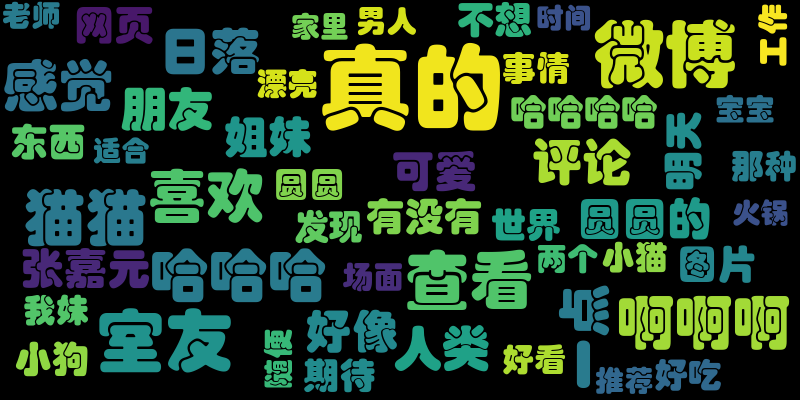

In [34]:
import jieba
from wordcloud import WordCloud
from HaoChiUtils import DataPreprocess as DP
from collections import Counter
import os
dp=DP(stopwords_file_path="stop_words.txt")
def get_wordcloud(folder_path):
    folders_list=os.listdir(folder_path)
    strs=" "
    for folder in folders_list:
        user_text_list=os.listdir(folder_path+'\\'+folder)
        print(folder)
        for user_text in user_text_list:

            file_path=folder_path+'\\'+folder+'\\'+user_text
            with open(file_path,'r',encoding='utf-8') as f:
                cnt=0
                for line in f:
                    cnt+=1
                    text=dp.text_clean(line,keep_segmentation=False)
                    text=text.split(' ')
                    text=[i for i in text if i!='' and len(i)>=2]
                    # print(text)
                    strs+=' '.join(text)
    return strs
folder_path="测试数据\8.5\正常用户"
seg_text=get_wordcloud(folder_path)
seg_list=seg_text.split(' ')
word_freq = Counter(seg_list)
top_n=50
top_words=dict(word_freq.most_common(top_n))
# 创建词云对象并生成词云
wordcloud = WordCloud(font_path='myttf.ttf', width=800, height=400).generate_from_frequencies(top_words)

# 显示词云
wordcloud.to_image()

# 显示词云
# wordcloud.to_image()